<img src = "https://drive.google.com/uc?export=view&id=1FNyRcLn_ZqLm263UvW1gEDW1_QaTr9hG" alt = "Encabezado MLDS" width = "100%">  </img>

# **Proyecto (Fase 5):** Reconocimiento vocal de ceatáceos
## **Giovanny Alejandro Cuervo Londoño**
---


### **Introducción**
---
La última fase de este proyecto se enfocó en la evaluación y desempeño de un modelo de reconocimiento de vocal de cetáceos utilizando técnicas de *Deep learning* y *Transfer learning*. El objetivo es desarrollar un sistema capaz de identificar y clasificar los diferentes tipos de vocalizaciones emitidas por los mamíferos marinos utilizando grabaciones de sus vocalizaciones caracteríticas.

En la actualidad, el avance de las técnicas de aprendizaje profundo, ha permitido el uso de modelos preentrenados, en particular el *Transfer learning*, la cual ha mostrado notables resultados en tareas de reconocimiento y clasificación. Dicha técnica permite implementar modelos complejos sin tener que emplear recursos computacionales en su entrenamiento, aprovechando así, su poder de extracción de características, para aplicarlos a problemas específicos con un conjunto de datos más limitado.

Siguendo este enfoque, se pretende utilizar técnicas de *Transfer learning* para implmentar el modelo **YAMNet** como un extractor de características para posterioremente entrenar una redensa como clasificador. Utilizando esta técnica se espera obtener resultados solidos y confiables despues de una evaluación exhaustiva a través de métricas de desempeño. Estos resultados podrán tener aplicaciones significativas en la conservación de estas especies, proporcionando una herramienta valiosa para el monitoreo de su comportamiento, la detección de patrones de migración y la evaluación del impacto de actividades humanas en su hábitat marino.

### Importamos e instalamos paquetes
---
Para el desarrollo del modelo fue necasario la instalación de los siguientes paquetes.

In [ ]:
# Instalamos algunos paquetes necasarios
!pip install noisereduce
!pip install ipython-autotime
!pip install tensorflow_io
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 66.4 MB/s eta 0:00:00
time: 251 µs (started: 2023-05-23 21:09:38 +00:00)


In [ ]:
# Importamos los modulos
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
# from IPython.display import Audio
import IPython.display as ipd
# Modulos extra
import librosa
import soundfile
import noisereduce as nr
import ast
import IPython.display as ipd
from numpy.random import randint
import scipy.io.wavfile as wav

time: 3.78 s (started: 2023-05-23 21:09:38 +00:00)


In [ ]:
# Seleccionamos una semilla para los RNG (Random Number Generator)
tf.random.set_seed(123)
np.random.seed(123)

time: 452 µs (started: 2023-05-23 21:09:41 +00:00)


### Importamos los datos
---
Debido a que el peso del conjunto de datos no excedia el almacenamiento otrogado en Colab, se decide realizar su tratamiento en la sesión actual.

In [ ]:
# Conectamos con nuestro google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 26.5 s (started: 2023-05-23 21:09:41 +00:00)


In [ ]:
# Cargamos nuestro datos a colab descomprimidos
!unzip "/content/drive/MyDrive/Proyecto/best-of-watkins-marine-mammal-sound-database.zip" -d ./content/

Streaming output truncated to the last 5000 lines.
  inflating: ./content/data/PantropicalSpottedDolphin/9400805V.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805W.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805X.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805Y.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805Z.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008060.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008061.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008062.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008063.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008064.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008065.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008066.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008067.wav  
  inflating: ./content/data/PantropicalSpottedDolphi

### Funciones predefinidas
---
Para las diferentes etapas del modelado fue necesario de finir una seria de funciones que facilitaran cada uno de los procesos implementados.

In [ ]:
def get_list_path_from_subfolders(dir):
    """
    Crea una lista de rutas para cada uno de los archivos
    dentro de subfolders que estan en un directorio
    """
    # Lista con las rutas de cada archivo
    file_paths = []
    # Iterar sobre los subdirectorios y archivos en dir base
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            # Obtener la ruta completa del archivo
            file_path = os.path.join(subdir, file)
            # Agregar la ruta completa del archivo a la lista file_paths
            file_paths.append(file_path)
    return file_paths

def get_df_labels_paths(list_paths):
    """
    Crea un df con dos columans
    clases o etiquetas y rutas o paths
    de los archivos de audio
    """
    # Diccionario con keys como columnas y values como datos para definir un df
    data = {'class': [os.path.basename(os.path.dirname(fp)) for fp in list_paths],
            'path': [fp for fp in list_paths]
            }
    # Dataframe a partir del diccionario datos
    return pd.DataFrame(data)

def get_rand_path(df):
    '''
    Seleccion aleatoria de un ruta con la misma probabilida
    entre las clases
    '''
    labels = df['class']
    # Obtiene las clases y su conteos
    classes, counts = np.unique(labels, return_counts=True)
    # Elige una clase de forma aleatoria
    rand_class = np.random.choice(classes)
    # Agrupa el df por la clase elegida
    df = df.loc[df['class'] == rand_class]
    # Elige una ruta al azar de la clase elegida
    series_path = np.random.choice(df['path'])
    # Ruta y clase aleatoria
    return series_path, rand_class

def framed_signal(y, sr):
    """
    Retorna una senal segmentada en frames
    """
    # Define la longitud de cada frame en segundos
    f_l = 0.05
    # Define el tamano en pasos del frame y su ventana deslizante
    f_l_samples = int(f_l * sr)
    # Define el tamano de la ventana
    frame_length = f_l_samples
    # Tamano del paso
    hop_length =f_l_samples
    # En el caso de audios muy cortos
    if len(y) < frame_length: # Solver: ParameterError: Input is too short {} for frame_length={}
        frame_length = len(y)
        hop_length = len(y)
    # Halla unos frames que solo se usaran como indices
    frames = librosa.util.frame(np.arange(len(y)),
                                frame_length = frame_length,
                                hop_length =hop_length
                              )
    # Define una lista de tuplas
    # Cada tupla es el idx inicial y final de cada frame
    frame_idx = [(i * hop_length+1,
                      i * hop_length + frame_length) for i in range(frames.shape[1])]
    # Hacemos cortes en la senal para defirnir los frame
    y_framed = [y[frame_idx[i][0]:frame_idx[i][1]] for i in range(len(frame_idx))]
    # Frames a nunpy
    y_framed = np.array(y_framed)
    # Senal segmentada
    return y_framed

def filtered_signal(y, sr):
    """
    Retorna una senal sin los frame mudos o los que
    no tienen el sonido caracteristico, por tanto son
    frames sin informacion
    """
    # Segmenta la senal
    mean_y = y.mean()
    std_y = y.std()
    # Definir umbral
    threshold = mean_y + 1 * std_y
    # Senal segmentada
    y_framed = framed_signal(y, sr)
    # Solo conserva los segmentos con vocalizaciones
    y_filtered = []
    for fram in y_framed:
        if np.max(abs(fram)) >= threshold:
            y_filtered.extend(fram)
    # Senal filtrada
    return np.array(y_filtered)

def load_wav_16k_mono(filename):
    """
    Carga un archivo WAV, lo convierte a un tensor con dtype float,
    resample a 16 kHz monocanal.
    """
    # Lee un audio de 8-bit
    fs, audio = wav.read(filename)
    # Convierte el audio a 16-bit formato int
    audio_16bit = (audio.astype('int16') - 128) * 256
    # Guarda el audio de 16-bit
    wav.write(filename, fs, audio_16bit)
    # Decodifica a binatio el archivo
    audio_16bit = tf.io.read_file(filename)
    # Convierte el audio a tensor
    wav_y, sample_rate = tf.audio.decode_wav(
          audio_16bit,
          desired_channels=1)
    # Elimina dimensiones de tamano 1
    wav_y = tf.squeeze(wav_y, axis=-1)
    # Cambia en dtype a int 64
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample de la senal
    wav_y = tfio.audio.resample(wav_y, rate_in=sample_rate, rate_out=16000)
    # Tensor senal y su sample rate
    return wav_y, sample_rate
# Definimos una serie de funciones para preprocesamiento para Yamnet
def load_wav_for_map(filename, label):
    """
    Wraper para de la funcion:
    * load_wav_16k_mono
    para el tf.data.Dataset.from_tensor_slices
    """
    # Convierte un tensor a numpy
    filename = filename.numpy().decode()
    y, sr = load_wav_16k_mono(filename)
    return y, sr, label

def proproces_for_map(y, sr):#, label):
    """
    Wraper para de la funciones:
    * nr.reduce_noise
    * filtered_signal
    para el tf.data.Dataset.from_tensor_slices
    """
    # Reduccion de ruido
    y, sr = y.numpy(), sr.numpy()
    if sr < 2**13: sr = 2**13 # Solver: freq_mask_smooth_hz needs to be at least {}Hz
    y = nr.reduce_noise(y = y, sr = sr,
                        n_std_thresh_stationary=1.5,
                        stationary=True, # True
                        )
    y = filtered_signal(y, sr)
    # Convertir el audio en un tensor TensorFlow
    #audio_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    return y, sr#audio_tensor, sr, label

# Extrae embedding de los datos para la entrada al modelo
def extract_embedding(wav_data):#, label):
    '''
    Extraccion de embeddings de datos tipo wav
    para la YAMNet
    '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return embeddings #(embeddings, tf.repeat(label, num_embeddings))
# Salta o descarta los datos que presenten error en load_wav_for_map
# Datos corruptos al pasar de 8 bits a 16 bits
def load_wav_for_map_skipErr(fname): #, label):
    try:
        # Si no hay error aplica la funcion
        # return load_wav_for_map(fname, label)
        return load_wav_16k_mono(pfile)
    except Exception as e:
        print(f'Error en load_wav_for_map_skipErr: {fname}')
        print(f"An error occurred: {e}")
        # Si hay error agrega a la lista la ruta problematica
        wav_Err_load16k.append(fname)
# Salta o descarta los datos que presenten error en proproces_for_map
def proproces_for_map_skipErr(y, sr, fname):#, label):
    try:
        # Si no hay error aplica la funcion
        return proproces_for_map(y, sr)#, label)
    except Exception as e:
        print(f'Error en proproces_for_map_skipErr: {fname}')
        print(f"An error occurred: {e}")
        # Si hay error agrega a la lista la ruta problematica
        wav_Err_preprocess.append(fname)
# Function wraper
def load_librosa_wraper_y(fpath):
    y, sr = librosa.load(fpath)
    return y
def load_librosa_wraper_sr(fpath):
    y, sr = librosa.load(fpath)
    return sr
# Data aumentation
def data_augment_freq_time(fpath):
    """
    Aumentacion de datos de audio utilizando:
    * Frequency masking
    * Time masking
    """
    audio = tfio.audio.AudioIOTensor(fpath)
    sr = audio.rate.numpy()
    y_squeeze = tf.squeeze(audio.to_tensor(), axis=[-1])
    y_tensor = tf.cast(y_squeeze, tf.float32) / 32768.0
    spectrogram = tfio.audio.spectrogram(y_tensor, nfft=512, window=512, stride=256)
    # Data aumentation
    freq_mask = tfio.audio.freq_mask(spectrogram, param=15)
    time_mask = tfio.audio.time_mask(freq_mask, param=15)
    time_spec_inver = tfio.audio.inverse_spectrogram(time_mask, nfft=512, window=512,
                                                     stride=256, iterations=30)
    # Retorna tensor float32
    return time_spec_inver.numpy().tolist()

def try_except_literal_eval(y):
    """
    Esta es un wraper de la funcion:
    * ast.literal_eval
    Para el caso [nan, nan, ..., nan]
    """
    try:
        y = ast.literal_eval(y)
    except Exception as e:
        print(f"Ocurrio un error: {str(e)} \nEn el dato: {y}")
        y = [0] * y.count('nan')
    return y

time: 4.01 ms (started: 2023-05-23 21:10:08 +00:00)


### Preprocesamiento
---
El proprocesamiento de las señales de audio consistio en tres etapas:
 > * Codificación de los audios de 8 bits a 16 bits (formato utilizado por YAMNet)

 > * Reducción de ruido utilizando el método del "umbral espectral"

 > * Supresión de silencio eliminando los intervalos de tiempo de en una señal donde no hay actividad sonora perceptible.


In [ ]:
dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
df = pd.read_csv(os.path.join(dir,'df_audios.csv'))
df

Unnamed: 0              class     file_name  \
0               0            Narwhal  7501400L.wav   
1               1            Narwhal  68003007.wav   
2               2            Narwhal  7501400U.wav   
3               3            Narwhal  7501400E.wav   
4               4            Narwhal  6800200A.wav   
...           ...                ...           ...   
15562       15562  WestIndianManatee  64036001.wav   
15563       15563  WestIndianManatee  64013003.wav   
15564       15564  WestIndianManatee  64036006.wav   
15565       15565  WestIndianManatee  64009009.wav   
15566       15566  WestIndianManatee  64036005.wav   

                                                path  length_min   size_MB  \
0                ./content/data/Narwhal/7501400L.wav    0.023633  0.221601   
1                ./content/data/Narwhal/68003007.wav    0.029922  0.140303   
2                ./content/data/Narwhal/7501400U.wav    0.023633  0.221601   
3                ./content/data/Narwhal/7501400E.wav    0.023633  0.221601   
4                ./content/data/Narwhal/6800200A.wav    0.023633  0.221601   
...                                              ...         ...       ...   
15562  ./content/data/WestIndianManatee/64036001.wav    0.017500  0.041059   
15563  ./content/data/WestIndianManatee/64013003.wav    0.009130  0.020941   
15564  ./content/data/WestIndianManatee/64036006.wav    0.014376  0.033735   
15565  ./content/data/WestIndianManatee/64009009.wav    0.054392  0.377258   
15566  ./content/data/WestIndianManatee/64036005.wav    0.014376  0.033735   

            SNR  
0      0.041813  
1      0.118808  
2      1.334958  
3      0.305832  
4      0.067411  
...         ...  
15562  0.456720  
15563  0.208792  
15564  3.720786  
15565  1.343921  
15566  2.379156  

[15567 rows x 7 columns]

time: 505 ms (started: 2023-05-20 00:23:54 +00:00)


In [ ]:
# Directorio base para guardar los archivos
base_dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
# Directorio para almacenar los archivos preprocesados
dir = 'preproces'
# Lista para almacenar los archivos de audio que presentan errores al cargarse
wav_Err_load16k = []
# Lista para almacenar los archivos de audio preprocesados que presentan errores
wav_Err_preprocess = []
# Itera sobre cada archivo de audio en la columna 'path' del dataframe 'df'
for pfile in df['path']:
    try:
        # Carga el archivo de audio utilizando la función 'load_wav_for_map_skipErr'
        y, sr = load_wav_for_map_skipErr(pfile)
        # Realiza el preprocesamiento del audio utilizando la función 'proproces_for_map_skipErr'
        y, sr = proproces_for_map_skipErr(y, sr, pfile)
        # Obtiene el nombre del directorio del archivo
        dfile = os.path.basename(os.path.dirname(pfile))
        # Si el directorio no existe, se crea
        if not os.path.exists(os.path.join(base_dir, dir, dfile)):
            os.makedirs(os.path.join(base_dir, dir, dfile))
        # Obtiene el nombre del archivo
        fname = os.path.basename(pfile)
        # Genera la nueva ruta para guardar el archivo preprocesado
        new_path = os.path.join(base_dir, dir, dfile, fname)
        # Escribe la salida de audio en un archivo
        soundfile.write(new_path, y, sr)
    except TypeError:
        # Si ocurre un error de tipo, continúa con la siguiente iteración
        continue

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=1014
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=858
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=871
  warnings.warn(


Error en load_wav_for_map_skipErr: ./content/data/PantropicalSpottedDolphin/84021003.wav
An error occurred: WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 40960, nBlockAlign = 2, and nAvgBytesPerSec = 61440
Error en load_wav_for_map_skipErr: ./content/data/ClymeneDolphin/8303503L.wav
An error occurred: WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 41600, nBlockAlign = 2, and nAvgBytesPerSec = 62400


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=381
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=367
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=288
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=361
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=483
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=267
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: 

time: 29min 9s (started: 2023-05-19 23:33:47 +00:00)


## Extracción de características
---
Utilizando las capas convolucionales de la YAMNet es posible realizar extracción de características para reducir la información de las señales de audio a su represenatción más simple. De manera que realizando el procedimiento anterioremente descrito fue posible extraer la representación en embeddings o vectores da cada uno de los audios.

In [ ]:
# Cargamos el modelo preentrenado Yamnet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

time: 8.03 s (started: 2023-05-23 05:57:43 +00:00)


In [ ]:
base_dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
dir = 'preproces'
list_path_ = get_list_path_from_subfolders(os.path.join(base_dir, dir))
df = get_df_labels_paths(list_path_)
# Crea un dict para codificar a entero las etiquetas
idx_label_dict = {label: i for i, label in enumerate(set(df['class']))}
# Define columna vacia al df iterado
df['label_encoded'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['label_encoded'] = df['class'].map(lambda clase: idx_label_dict[clase])
# Define columna vacia al df iterado
df['y'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['y'] = df['path'].map(lambda clase: load_librosa_wraper_y(clase))
# Define columna vacia al df iterado
df['sr'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['sr'] = df['path'].map(lambda clase: load_librosa_wraper_sr(clase))
# Define columna vacia al df iterado
df['embedings'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['embedings'] = df['y'].map(lambda clase: extract_embedding(clase).numpy().tolist()[0])
df

class                                               path  \
0            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
1            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
2            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
3            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
4            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                 ...                                                ...   
15558  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15559  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15560  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15561  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15562  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   

       label_encoded                                                  y  \
0                 52  [-0.007251107, -0.009141629, -0.008274404, -0....   
1                 52  [0.008003657, 0.010150915, 0.009304976, 0.0086...   
2                 52  [0.005239184, 0.0066251755, 0.00603486, 0.0055...   
3                 52  [0.010244083, 0.013345191, 0.012832259, 0.0125...   
4                 52  [-0.0064355195, -0.007949391, -0.0069006914, -...   
...              ...                                                ...   
15558             45  [-0.0006619792, 2.6298549e-06, -0.00035502185,...   
15559             45  [0.00031549972, 0.0014018245, 0.00012754163, -...   
15560             45  [-0.00016519772, -0.0007656903, 0.0010500322, ...   
15561             45  [-0.0005172442, -0.0010374866, 0.00033471995, ...   
15562             45  [0.00013972605, -0.000743796, -0.00029611983, ...   

          sr                                          embedings  
0      22050  [0.0, 0.00014587242912966758, 0.0, 0.0, 0.0, 0...  
1      22050  [0.0, 0.0, 0.0, 0.0, 0.047039199620485306, 0.0...  
2      22050  [0.007741590496152639, 0.0, 0.0, 0.00621175253...  
3      22050  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4      22050  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...      ...                                                ...  
15558  22050  [0.0, 1.5332794189453125, 0.08786789327859879,...  
15559  22050  [0.0, 0.06617972999811172, 0.3292279839515686,...  
15560  22050  [0.0, 2.0022830963134766, 0.0, 0.0, 0.0, 0.0, ...  
15561  22050  [0.0, 0.29933926463127136, 0.12819483876228333...  
15562  22050  [0.027879804372787476, 0.05319677293300629, 0....  

[15563 rows x 6 columns]

time: 23min 32s (started: 2023-05-20 00:24:08 +00:00)


In [ ]:
dir = os.path.join(base_dir, dir)
df.to_csv(os.path.join(dir, 'df_data_preproces.csv'), index=False)

In [ ]:
# base_dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
base_dir = '/content/drive/MyDrive/Proyecto/'
dir = 'preproces'
dir = os.path.join(base_dir, dir)
df_for_dataset = pd.read_csv(os.path.join(dir,'df_data_preproces.csv'))
df_for_dataset

class                                               path  \
0            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
1            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
2            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
3            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
4            MinkeWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                 ...                                                ...   
15558  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15559  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15560  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15561  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
15562  MelonHeadedWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   

       label_encoded                                                  y  \
0                 52  [-0.00725111 -0.00914163 -0.0082744  ... -0.01...   
1                 52  [ 0.00800366  0.01015092  0.00930498 ... -0.03...   
2                 52  [0.00523918 0.00662518 0.00603486 ... 0.099391...   
3                 52  [0.01024408 0.01334519 0.01283226 ... 0.061850...   
4                 52  [-0.00643552 -0.00794939 -0.00690069 ... -0.00...   
...              ...                                                ...   
15558             45  [-6.6197920e-04  2.6298549e-06 -3.5502185e-04 ...   
15559             45  [0.0003155  0.00140182 0.00012754 ... 0.002101...   
15560             45  [-1.6519772e-04 -7.6569029e-04  1.0500322e-03 ...   
15561             45  [-0.00051724 -0.00103749  0.00033472 ...  0.00...   
15562             45  [ 1.39726049e-04 -7.43796001e-04 -2.96119833e-...   

          sr                                          embedings  
0      22050  [0.0, 0.00014587242912966758, 0.0, 0.0, 0.0, 0...  
1      22050  [0.0, 0.0, 0.0, 0.0, 0.047039199620485306, 0.0...  
2      22050  [0.007741590496152639, 0.0, 0.0, 0.00621175253...  
3      22050  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4      22050  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...      ...                                                ...  
15558  22050  [0.0, 1.5332794189453125, 0.08786789327859879,...  
15559  22050  [0.0, 0.06617972999811172, 0.3292279839515686,...  
15560  22050  [0.0, 2.0022830963134766, 0.0, 0.0, 0.0, 0.0, ...  
15561  22050  [0.0, 0.29933926463127136, 0.12819483876228333...  
15562  22050  [0.027879804372787476, 0.05319677293300629, 0....  

[15563 rows x 6 columns]

time: 2.66 s (started: 2023-05-23 03:19:41 +00:00)


## Desbalance de clases
---
Es posible identificar un claro desbalance en los datos, l analizar la cantidad de señales de audio por clase, que puede afectar el desempeño de la red a la hora de clasificar las clases con menos muestras. Por lo que se evidencia la necesidad de emplear metodologías de aumentación de datos para solventar los efectos negativos de este desbalance.

In [ ]:
# Nuevo data set con datos balanceados
fig = plt.figure(figsize=(18, 6))
sorted_class_ascend = df_for_dataset['class'].value_counts()
fig = sns.barplot(x=sorted_class_ascend.index, y=sorted_class_ascend.values, palette="pastel")
plt.xticks(rotation=45, ha="right")
plt.title(f"Numero de audios por clase ({len(set(df_for_dataset['class']))})", fontsize=16);
plt.ylabel(f'N: {df_for_dataset.shape[0]}')
plt.xlabel('Clase')
plt.tight_layout()

time: 939 ms (started: 2023-05-20 13:48:28 +00:00)


In [ ]:
# Particion del conjunto de datos
from sklearn.model_selection import train_test_split
# Define conjuntos: train y test
X_train_val, X_test, y_train_val, y_test = train_test_split(df_for_dataset[['path', 'y', 'embedings']],
                                                    df_for_dataset[['label_encoded', 'class']],
                                                    test_size=0.1,
                                                    random_state=42
                                                    )
print(f'X_train size: {X_train_val.shape} \ny_train size: {y_train_val.shape}')
print(f'X_test size: {X_test.shape} \ny_test size: {y_test.shape}')

X_train size: (14006, 3) 
y_train size: (14006, 2)
X_test size: (1557, 3) 
y_test size: (1557, 2)
time: 208 ms (started: 2023-05-23 03:19:49 +00:00)


In [ ]:
# Define conjuntos: train y test
X_train, X_val, y_train, y_val = train_test_split(X_train_val[['path', 'y', 'embedings']],
                                                  y_train_val[['label_encoded', 'class']],
                                                  test_size=0.3,
                                                  random_state=42
                                                  )
print(f'X_train size: {X_train.shape} \ny_train size: {y_train.shape}')
print(f'X_test size: {X_val.shape} \ny_test size: {y_val.shape}')

X_train size: (9804, 3) 
y_train size: (9804, 2)
X_test size: (4202, 3) 
y_test size: (4202, 2)
time: 9.75 ms (started: 2023-05-23 03:19:51 +00:00)


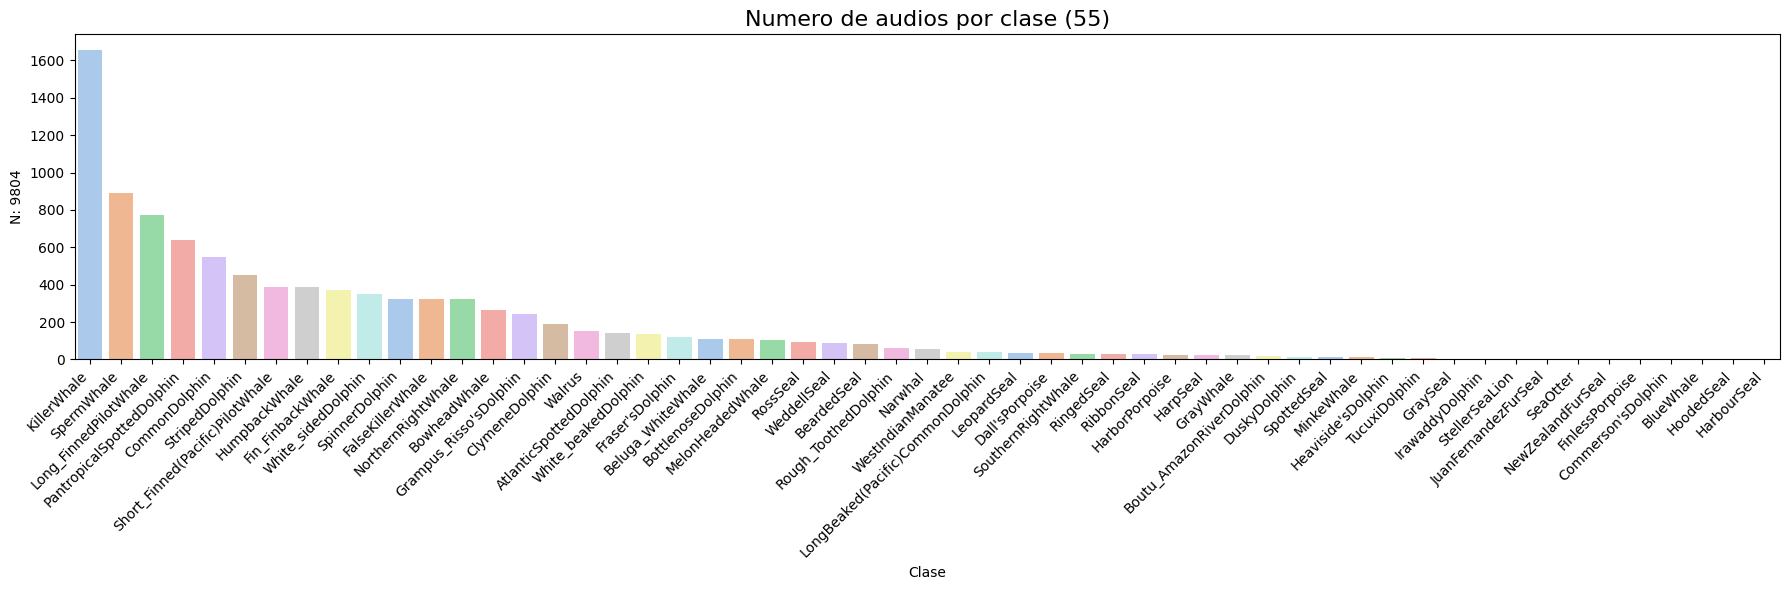

time: 1.18 s (started: 2023-05-20 13:48:40 +00:00)


In [ ]:
# Nuevo data set con datos balanceados
fig = plt.figure(figsize=(18, 6))
sorted_class_ascend = y_train['class'].value_counts()
fig = sns.barplot(x=sorted_class_ascend.index, y=sorted_class_ascend.values, palette="pastel")
plt.xticks(rotation=45, ha="right")
plt.title(f"Numero de audios por clase ({len(set(y_train['class']))})", fontsize=16);
plt.ylabel(f'N: {y_train.shape[0]}')
plt.xlabel('Clase')
plt.tight_layout()

## Aumentación de datos
---
Se realizó la aumentación de datos utilizando dos técnicas:

* Frequency masking
* Time masking

In [ ]:
# Balance de datos Data aumentation
# Crea un dataframe vacio para iteracion
df_aument = pd.DataFrame(columns=['class', 'path', 'y'])
# Iteramos en cada una de las rutas
count = 1
for _ in range(len(X_train['path'][9000:])):
    print(count)
    # Elige una ruta y respectiva etiqueta de forma aletoria
    signal_path, label = get_rand_path(pd.concat([X_train, y_train], axis=1))
    # Aumentacion de datos
    # Data_augment_freq_time es aleatoria en sus parametros
    # Puede tener errores en ciertas iteraciones
    # Por lo que se debe volver a correr cada vez que tenemos un error
    while True:
        try:
            audio_length = librosa.load(signal_path)[0].shape[0]
            if audio_length == 0:
                break
            y = data_augment_freq_time(signal_path)
        except Exception as e:
            print(f"Ocurrio un error: {str(e)} \nVolviendolo a intentar...N. {count}")
            continue
        else:
            count += 1
            break
    # Crea un df de una fila con la ruta y etiqueta elegida
    df_2 = pd.DataFrame({'class': [label],
                         'path': [signal_path],
                         'y': [y]})
    # Concatena o agrega dicha ruta al df vacio
    df_aument = pd.concat([df_aument, df_2],
                               ignore_index=True)
# Crea un dict para codificar a entero las etiquetas
idx_label_dict = {label: i for i, label in enumerate(set(df_aument['class']))}
# Define columna vacia al df iterado
df_aument['label_encoded'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df_aument['label_encoded'] = df_aument['class'].map(lambda clase: idx_label_dict[clase])
# Codifica a one hot las etiquetas
one_hot_labels = tf.keras.utils.to_categorical(df_aument['label_encoded'])
# Define una columana con las etiquetas codificadas en one hot
df_aument['one_hot'] = one_hot_labels.tolist()
# Dataframe con clases balanceadas
dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
# dir = '/content/drive/MyDrive/Proyecto/'
df_aument.to_csv(dir+'df_train_aumenta_9804.csv', index=False)

1
2
3
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -3 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 3
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -4 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 3
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -1 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 3
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= 0 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 3
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -1 [Op:RandomUniformInt] 
Volviendol

In [ ]:
# dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
dir = '/content/drive/MyDrive/Proyecto/'
df_1500 = pd.read_csv(os.path.join(dir,'df_train_aumenta_1500.csv'))
df_3000 = pd.read_csv(os.path.join(dir,'df_train_aumenta_3000.csv'))
df_4500 = pd.read_csv(os.path.join(dir,'df_train_aumenta_4500.csv'))
df_6000 = pd.read_csv(os.path.join(dir,'df_train_aumenta_6000.csv'))
df_7500 = pd.read_csv(os.path.join(dir,'df_train_aumenta_7500.csv'))
df_9000 = pd.read_csv(os.path.join(dir,'df_train_aumenta_9000.csv'))
df_9804 = pd.read_csv(os.path.join(dir,'df_train_aumenta_9804.csv'))
df_for_dataset = pd.concat([df_1500, df_3000, df_4500, df_6000, df_7500, df_9000, df_9804], axis=0).reset_index(drop=True)
df_for_dataset

class                                               path  \
0          SpinnerDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
1             LeopardSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
2              RingedSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
3          HarborPorpoise  /content/drive/MyDrive/Python/Deep learning/Pr...   
4      Heaviside'sDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                   ...                                                ...   
9799    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9800    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9801           SpermWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9802          KillerWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9803  White_beakedDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   

                                                      y  label_encoded  \
0     [0.0, 2.473063354102578e-08, 3.999021558342974...             54   
1     [0.0, 1.5878953263381845e-08, 9.32216526194906...             44   
2     [0.0, 1.4705859641139796e-08, -1.1028444646399...             10   
3     [0.0, -3.491551936463111e-08, 1.33553754722015...             29   
4     [0.0, 2.5864649089157865e-08, 1.81810705157658...              1   
...                                                 ...            ...   
9799  [0.0, 3.394675118784107e-08, -5.76747467562199...             47   
9800  [0.0, -1.793800130656109e-08, 5.54732899615828...             47   
9801  [0.0, -1.8987982297602457e-09, 2.0839744152567...             44   
9802  [0.0, -7.703521731627916e-08, -8.4572413072692...             50   
9803  [0.0, 5.1133067557884715e-08, 3.91504357821759...             24   

                                                one_hot  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                 ...  
9799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9800  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9801  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9802  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9803  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[9804 rows x 5 columns]

time: 5min 39s (started: 2023-05-22 22:47:05 +00:00)


In [ ]:
dir = '/content/drive/MyDrive/Proyecto/'
df_for_dataset.to_csv(dir+'df_train_aumenta_TOT.csv', index=False)

time: 8min 41s (started: 2023-05-22 22:53:53 +00:00)


In [ ]:
dir = '/content/drive/MyDrive/Proyecto/'
df_for_dataset = pd.read_csv(os.path.join(dir,'df_train_aumenta_TOT.csv'))
df_for_dataset

class                                               path  \
0          SpinnerDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
1             LeopardSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
2              RingedSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
3          HarborPorpoise  /content/drive/MyDrive/Python/Deep learning/Pr...   
4      Heaviside'sDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                   ...                                                ...   
9799    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9800    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9801           SpermWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9802          KillerWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9803  White_beakedDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   

                                                      y  label_encoded  \
0     [0.0, 2.473063354102578e-08, 3.999021558342974...             54   
1     [0.0, 1.5878953263381845e-08, 9.32216526194906...             44   
2     [0.0, 1.4705859641139796e-08, -1.1028444646399...             10   
3     [0.0, -3.491551936463111e-08, 1.33553754722015...             29   
4     [0.0, 2.5864649089157865e-08, 1.81810705157658...              1   
...                                                 ...            ...   
9799  [0.0, 3.394675118784107e-08, -5.76747467562199...             47   
9800  [0.0, -1.793800130656109e-08, 5.54732899615828...             47   
9801  [0.0, -1.8987982297602457e-09, 2.0839744152567...             44   
9802  [0.0, -7.703521731627916e-08, -8.4572413072692...             50   
9803  [0.0, 5.1133067557884715e-08, 3.91504357821759...             24   

                                                one_hot  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                 ...  
9799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9800  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9801  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9802  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
9803  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[9804 rows x 5 columns]

time: 2min 15s (started: 2023-05-22 23:20:15 +00:00)


In [ ]:
# Nuevo data set con datos balanceados
fig = plt.figure(figsize=(18, 6))
sorted_class_ascend = df_for_dataset['class'].value_counts()
fig = sns.barplot(x=sorted_class_ascend.index, y=sorted_class_ascend.values, palette="pastel")
plt.xticks(rotation=45, ha="right")
plt.title(f"Numero de audios por clase ({len(set(df_for_dataset['class']))})", fontsize=16);
plt.ylabel(f'N: {df_for_dataset.shape[0]}')
plt.xlabel('Clase')
plt.tight_layout()

time: 1.08 s (started: 2023-05-22 23:22:45 +00:00)


In [ ]:
# Define columna vacia al df iterado
df_for_dataset['embedings'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df_for_dataset['embedings'] = df_for_dataset['y'].map(lambda clase: extract_embedding(try_except_literal_eval(clase)).numpy().tolist()[0])
df_for_dataset

class                                               path  \
0          SpinnerDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
1             LeopardSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
2              RingedSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
3          HarborPorpoise  /content/drive/MyDrive/Python/Deep learning/Pr...   
4      Heaviside'sDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                   ...                                                ...   
9799    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9800    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9801           SpermWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9802          KillerWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9803  White_beakedDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   

                                                      y  label_encoded  \
0     [0.0, 2.473063354102578e-08, 3.999021558342974...             54   
1     [0.0, 1.5878953263381845e-08, 9.32216526194906...             44   
2     [0.0, 1.4705859641139796e-08, -1.1028444646399...             10   
3     [0.0, -3.491551936463111e-08, 1.33553754722015...             29   
4     [0.0, 2.5864649089157865e-08, 1.81810705157658...              1   
...                                                 ...            ...   
9799  [0.0, 3.394675118784107e-08, -5.76747467562199...             47   
9800  [0.0, -1.793800130656109e-08, 5.54732899615828...             47   
9801  [0.0, -1.8987982297602457e-09, 2.0839744152567...             44   
9802  [0.0, -7.703521731627916e-08, -8.4572413072692...             50   
9803  [0.0, 5.1133067557884715e-08, 3.91504357821759...             24   

                                                one_hot  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                 ...   
9799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9800  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9801  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9802  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9803  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              embedings  
0     [0.0, 0.0, 0.4653263986110687, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.07573214918375015, 0.0, 0.212348520755...  
2     [0.0, 0.0, 0.018954234197735786, 0.01717922277...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 0.44901755452156067, 0.03473677858710289...  
...                                                 ...  
9799  [0.0, 0.05693936347961426, 1.186111330986023, ...  
9800  [0.0, 0.0, 1.0869635343551636, 0.0, 0.0, 0.0, ...  
9801  [0.0, 0.0044310870580375195, 0.012087352573871...  
9802  [0.0, 0.8514938354492188, 0.1657840609550476, ...  
9803  [0.0, 0.9279767870903015, 0.5714767575263977, ...  

[9804 rows x 6 columns]

time: 1h 42min 53s (started: 2023-05-22 23:23:30 +00:00)


In [ ]:
df_for_dataset

class                                               path  \
0          SpinnerDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
1             LeopardSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
2              RingedSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
3          HarborPorpoise  /content/drive/MyDrive/Python/Deep learning/Pr...   
4      Heaviside'sDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                   ...                                                ...   
9799    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9800    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9801           SpermWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9802          KillerWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9803  White_beakedDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   

                                                      y  label_encoded  \
0     [0.0, 2.473063354102578e-08, 3.999021558342974...             54   
1     [0.0, 1.5878953263381845e-08, 9.32216526194906...             44   
2     [0.0, 1.4705859641139796e-08, -1.1028444646399...             10   
3     [0.0, -3.491551936463111e-08, 1.33553754722015...             29   
4     [0.0, 2.5864649089157865e-08, 1.81810705157658...              1   
...                                                 ...            ...   
9799  [0.0, 3.394675118784107e-08, -5.76747467562199...             47   
9800  [0.0, -1.793800130656109e-08, 5.54732899615828...             47   
9801  [0.0, -1.8987982297602457e-09, 2.0839744152567...             44   
9802  [0.0, -7.703521731627916e-08, -8.4572413072692...             50   
9803  [0.0, 5.1133067557884715e-08, 3.91504357821759...             24   

                                                one_hot  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                 ...   
9799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9800  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9801  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9802  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9803  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              embedings  
0     [0.0, 0.0, 0.4653263986110687, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.07573214918375015, 0.0, 0.212348520755...  
2     [0.0, 0.0, 0.018954234197735786, 0.01717922277...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 0.44901755452156067, 0.03473677858710289...  
...                                                 ...  
9799  [0.0, 0.05693936347961426, 1.186111330986023, ...  
9800  [0.0, 0.0, 1.0869635343551636, 0.0, 0.0, 0.0, ...  
9801  [0.0, 0.0044310870580375195, 0.012087352573871...  
9802  [0.0, 0.8514938354492188, 0.1657840609550476, ...  
9803  [0.0, 0.9279767870903015, 0.5714767575263977, ...  

[9804 rows x 6 columns]

time: 28.6 ms (started: 2023-05-23 02:26:31 +00:00)


In [ ]:
dir = '/content/drive/MyDrive/Proyecto/'
df_for_dataset.to_csv(dir+'df_train_aumenta_TOT_embed.csv', index=False)

time: 8min 44s (started: 2023-05-23 02:26:57 +00:00)


In [ ]:
dir = '/content/drive/MyDrive/Proyecto/'
df_for_dataset = pd.read_csv(os.path.join(dir,'df_train_aumenta_TOT_embed.csv'))
df_for_dataset

class                                               path  \
0          SpinnerDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
1             LeopardSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
2              RingedSeal  /content/drive/MyDrive/Python/Deep learning/Pr...   
3          HarborPorpoise  /content/drive/MyDrive/Python/Deep learning/Pr...   
4      Heaviside'sDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
...                   ...                                                ...   
9799    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9800    BottlenoseDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   
9801           SpermWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9802          KillerWhale  /content/drive/MyDrive/Python/Deep learning/Pr...   
9803  White_beakedDolphin  /content/drive/MyDrive/Python/Deep learning/Pr...   

                                                      y  label_encoded  \
0     [0.0, 2.473063354102578e-08, 3.999021558342974...             54   
1     [0.0, 1.5878953263381845e-08, 9.32216526194906...             44   
2     [0.0, 1.4705859641139796e-08, -1.1028444646399...             10   
3     [0.0, -3.491551936463111e-08, 1.33553754722015...             29   
4     [0.0, 2.5864649089157865e-08, 1.81810705157658...              1   
...                                                 ...            ...   
9799  [0.0, 3.394675118784107e-08, -5.76747467562199...             47   
9800  [0.0, -1.793800130656109e-08, 5.54732899615828...             47   
9801  [0.0, -1.8987982297602457e-09, 2.0839744152567...             44   
9802  [0.0, -7.703521731627916e-08, -8.4572413072692...             50   
9803  [0.0, 5.1133067557884715e-08, 3.91504357821759...             24   

                                                one_hot  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                 ...   
9799  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9800  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9801  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9802  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9803  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              embedings  
0     [0.0, 0.0, 0.4653263986110687, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.07573214918375015, 0.0, 0.212348520755...  
2     [0.0, 0.0, 0.018954234197735786, 0.01717922277...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 0.44901755452156067, 0.03473677858710289...  
...                                                 ...  
9799  [0.0, 0.05693936347961426, 1.186111330986023, ...  
9800  [0.0, 0.0, 1.0869635343551636, 0.0, 0.0, 0.0, ...  
9801  [0.0, 0.0044310870580375195, 0.012087352573871...  
9802  [0.0, 0.8514938354492188, 0.1657840609550476, ...  
9803  [0.0, 0.9279767870903015, 0.5714767575263977, ...  

[9804 rows x 6 columns]

time: 3min 9s (started: 2023-05-23 21:10:08 +00:00)


### Reducción de la dimensionalidad
---
Se aplicó un t-SNE al conjunto de entrenamiento aumentado para observar la distribución de los datos en un espacio latente. Esto nos puede dar una noción sobre la dificultad de que tendría el modelo para realizar la clasifiacción. Dado que las categorías, que en el espacio latente, se observen muy parecidas entre si pueden ser muy dificiles de clasificar para el modelo.

In [ ]:
from sklearn.manifold import TSNE
# Utilizamos TSNE para visualizar el espacio de los tópicos
tsne = TSNE(
        n_components=2,
        random_state=0,
        n_iter=1000,
        perplexity=1500,
        verbose=1
        )
tsne_data = np.array(df_for_dataset['embedings'].apply(ast.literal_eval).tolist())
T = tsne.fit_transform(tsne_data)

[t-SNE] Computing 4501 nearest neighbors...
[t-SNE] Indexed 9804 samples in 0.007s...
[t-SNE] Computed neighbors for 9804 samples in 4.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9804
[t-SNE] Computed conditional probabilities for sample 2000 / 9804
[t-SNE] Computed conditional probabilities for sample 3000 / 9804
[t-SNE] Computed conditional probabilities for sample 4000 / 9804
[t-SNE] Computed conditional probabilities for sample 5000 / 9804
[t-SNE] Computed conditional probabilities for sample 6000 / 9804
[t-SNE] Computed conditional probabilities for sample 7000 / 9804
[t-SNE] Computed conditional probabilities for sample 8000 / 9804
[t-SNE] Computed conditional probabilities for sample 9000 / 9804
[t-SNE] Computed conditional probabilities for sample 9804 / 9804
[t-SNE] Mean sigma: 3.094002
[t-SNE] KL divergence after 50 iterations with early exaggeration: 49.953659
[t-SNE] KL divergence after 1000 iterations: 0.530569
time: 6min 26s (started: 2023-05-23 2

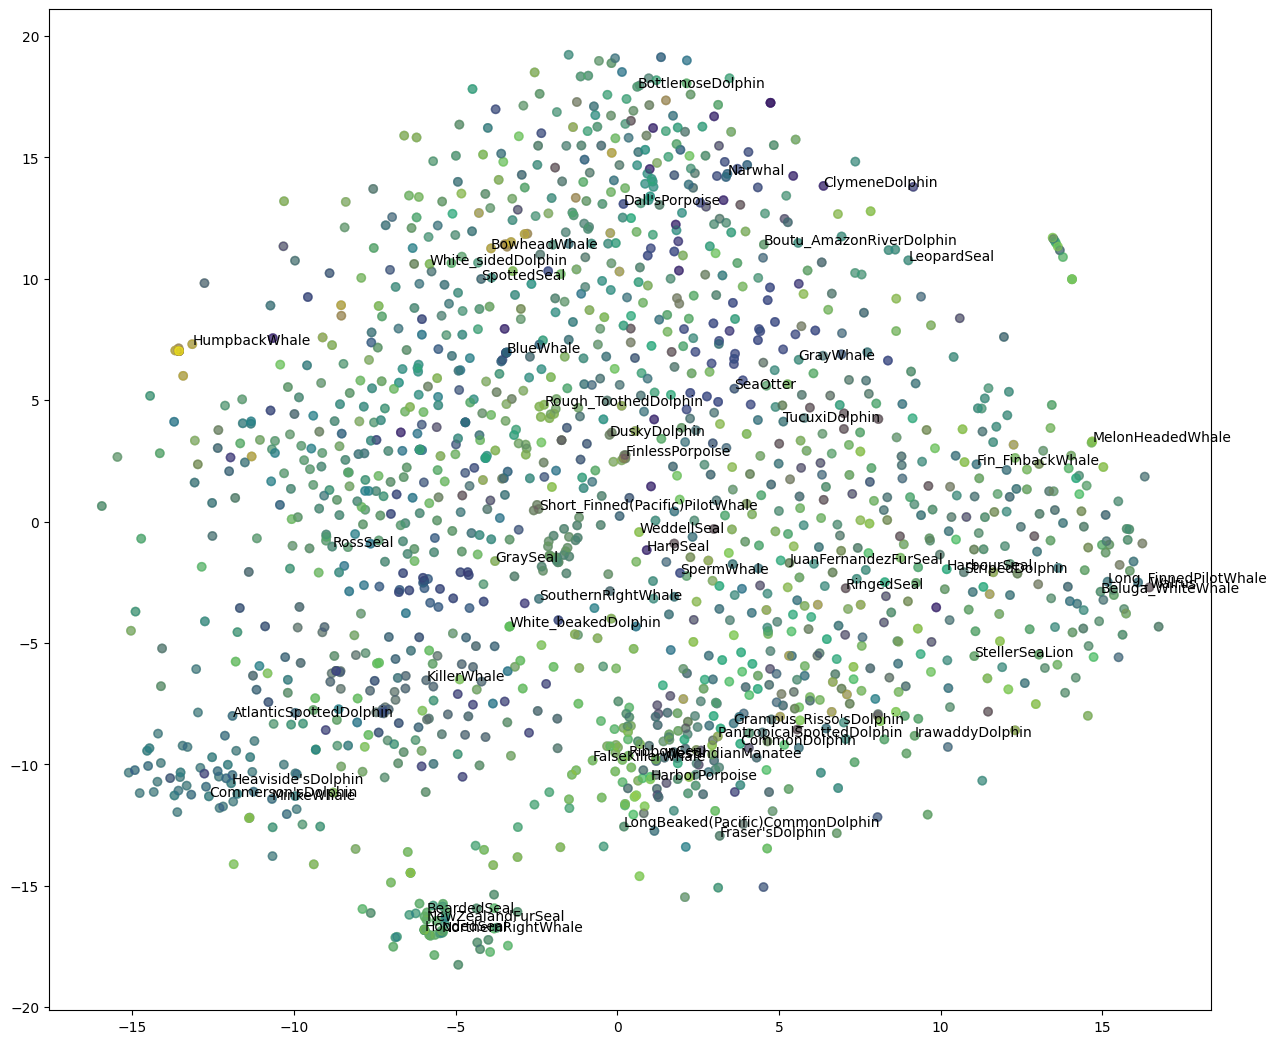

time: 978 ms (started: 2023-05-23 21:39:22 +00:00)


In [ ]:
plt.figure(figsize=(15, 13))
n_docs = df_for_dataset['label_encoded'].max()
idx = np.arange(df_for_dataset['label_encoded'].max())
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(
        T[:, 0], T[:, 1],
        c=df_for_dataset['label_encoded'],
        alpha=0.2
        )
viz_titles = [df_for_dataset[df_for_dataset['label_encoded']==i]['class'].unique()[0] for i in valid_idx]
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(
            label,
            xy=(x, y),
            xytext=(0, 0),
            textcoords='offset points'
            )

In [ ]:
from sklearn.manifold import TSNE
# Utilizamos TSNE para visualizar el espacio de los tópicos
tsne = TSNE(
        n_components=2,
        random_state=0,
        n_iter=1000,
        perplexity=100,
        verbose=1
        )
tsne_data = np.array(df_for_dataset['embedings'].apply(ast.literal_eval).tolist())
T = tsne.fit_transform(tsne_data)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 9804 samples in 0.007s...
[t-SNE] Computed neighbors for 9804 samples in 1.622s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9804
[t-SNE] Computed conditional probabilities for sample 2000 / 9804
[t-SNE] Computed conditional probabilities for sample 3000 / 9804
[t-SNE] Computed conditional probabilities for sample 4000 / 9804
[t-SNE] Computed conditional probabilities for sample 5000 / 9804
[t-SNE] Computed conditional probabilities for sample 6000 / 9804
[t-SNE] Computed conditional probabilities for sample 7000 / 9804
[t-SNE] Computed conditional probabilities for sample 8000 / 9804
[t-SNE] Computed conditional probabilities for sample 9000 / 9804
[t-SNE] Computed conditional probabilities for sample 9804 / 9804
[t-SNE] Mean sigma: 2.334959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.960037
[t-SNE] KL divergence after 1000 iterations: 0.365158
time: 57.1 s (started: 2023-05-23 21:

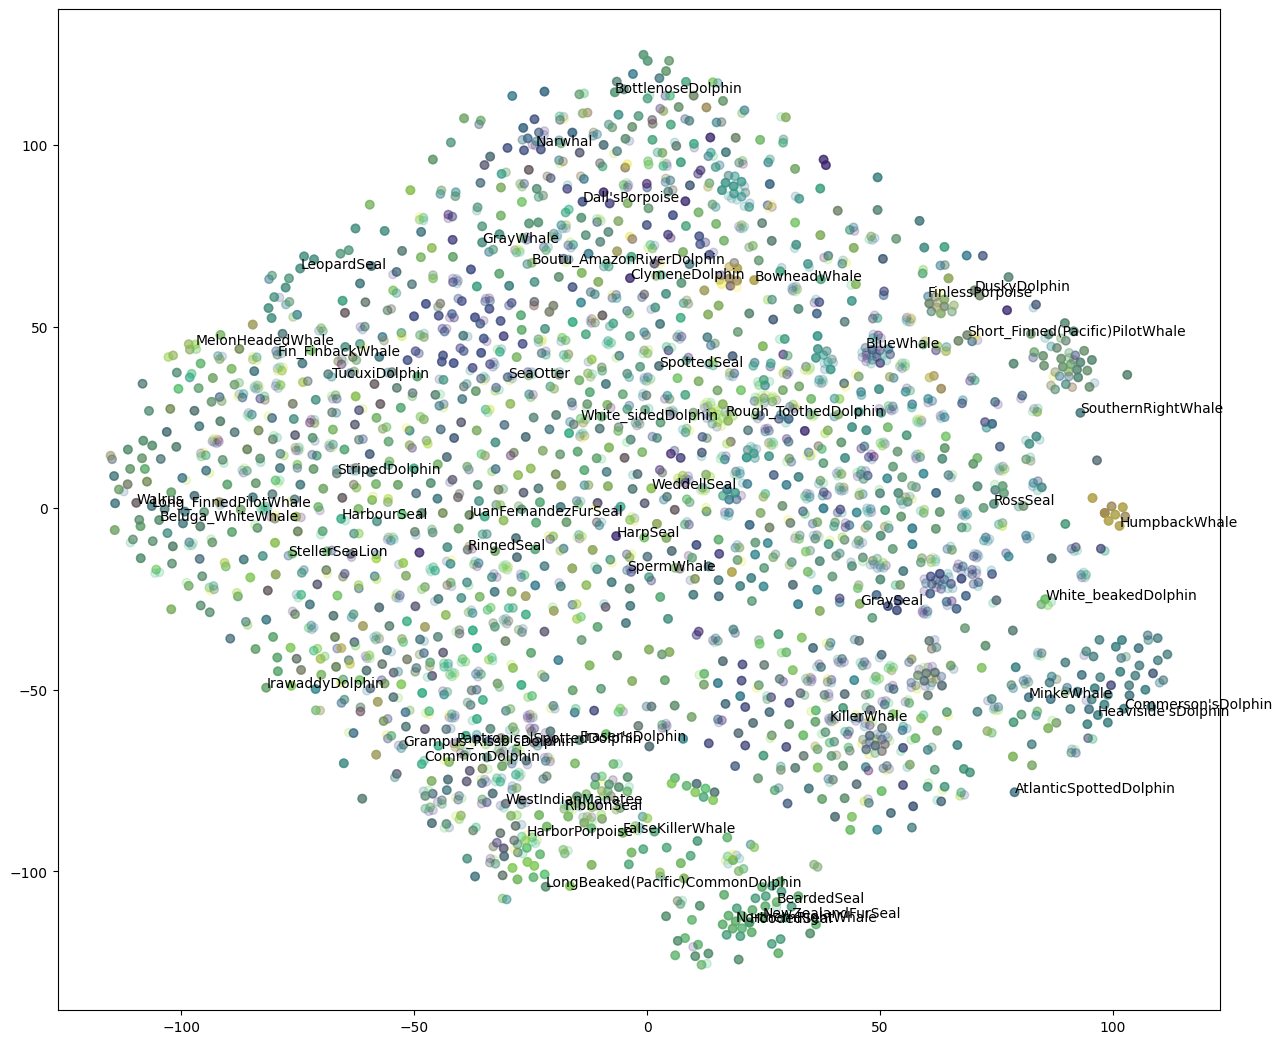

time: 974 ms (started: 2023-05-23 21:40:41 +00:00)


In [ ]:
plt.figure(figsize=(15, 13))
n_docs = df_for_dataset['label_encoded'].max()
idx = np.arange(df_for_dataset['label_encoded'].max())
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(
        T[:, 0], T[:, 1],
        c=df_for_dataset['label_encoded'],
        alpha=0.2
        )
viz_titles = [df_for_dataset[df_for_dataset['label_encoded']==i]['class'].unique()[0] for i in valid_idx]
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(
            label,
            xy=(x, y),
            xytext=(0, 0),
            textcoords='offset points'
            )

In [ ]:
from sklearn.manifold import TSNE
# Utilizamos TSNE para visualizar el espacio de los tópicos
tsne = TSNE(
        n_components=2,
        random_state=0,
        n_iter=1000,
        perplexity=200,
        verbose=1
        )
tsne_data = np.array(df_for_dataset['embedings'].apply(ast.literal_eval).tolist())
T = tsne.fit_transform(tsne_data)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 9804 samples in 0.007s...
[t-SNE] Computed neighbors for 9804 samples in 2.503s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9804
[t-SNE] Computed conditional probabilities for sample 2000 / 9804
[t-SNE] Computed conditional probabilities for sample 3000 / 9804
[t-SNE] Computed conditional probabilities for sample 4000 / 9804
[t-SNE] Computed conditional probabilities for sample 5000 / 9804
[t-SNE] Computed conditional probabilities for sample 6000 / 9804
[t-SNE] Computed conditional probabilities for sample 7000 / 9804
[t-SNE] Computed conditional probabilities for sample 8000 / 9804
[t-SNE] Computed conditional probabilities for sample 9000 / 9804
[t-SNE] Computed conditional probabilities for sample 9804 / 9804
[t-SNE] Mean sigma: 2.519987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.446472
[t-SNE] KL divergence after 1000 iterations: 0.474298
time: 1min 31s (started: 2023-05-23 2

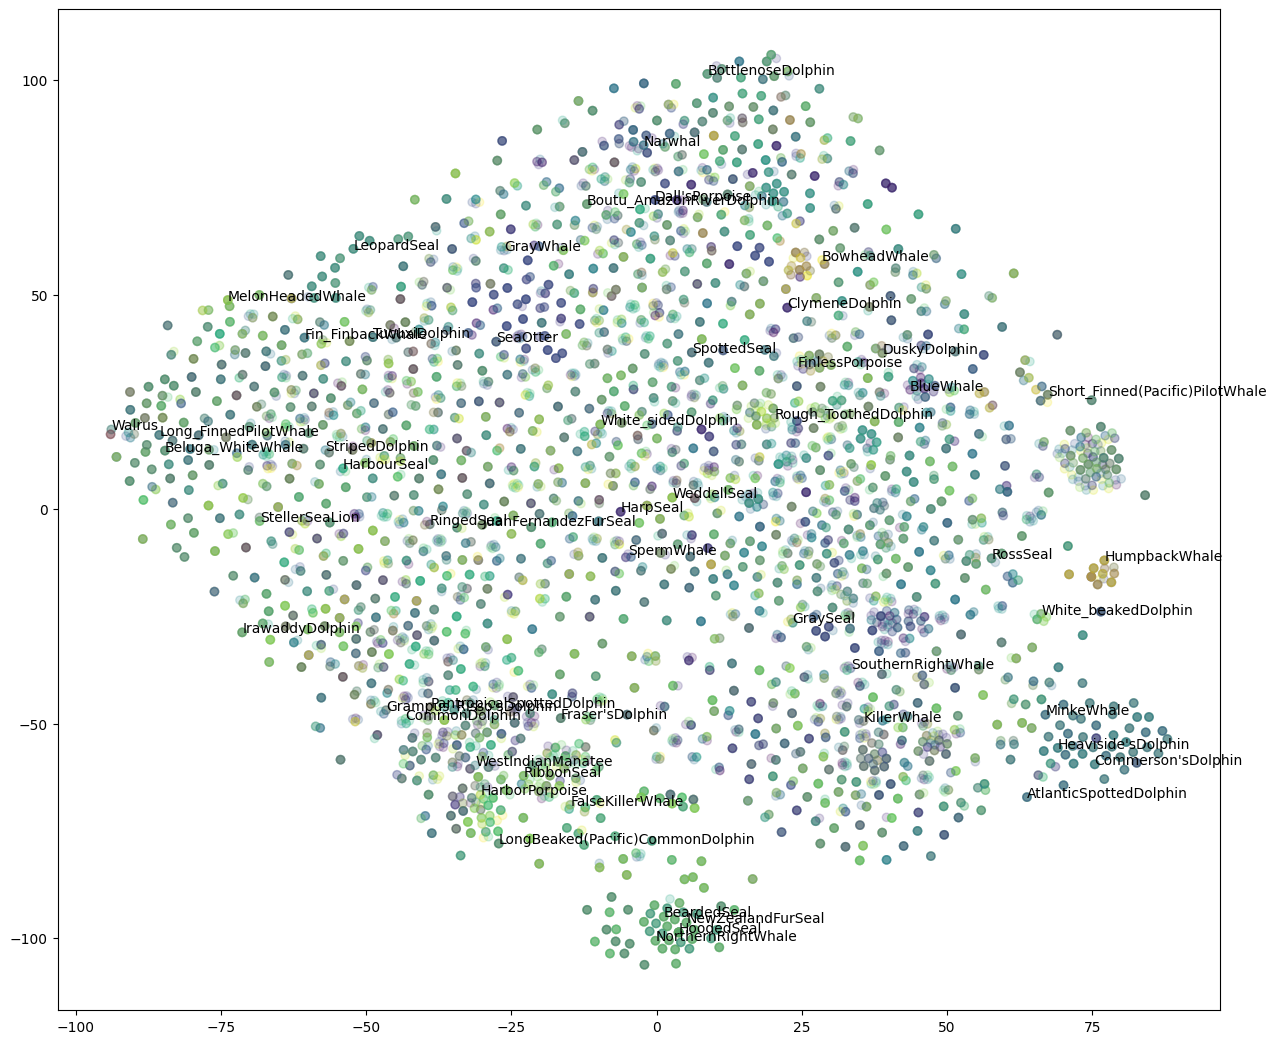

time: 987 ms (started: 2023-05-23 21:43:30 +00:00)


In [ ]:
plt.figure(figsize=(15, 13))
n_docs = df_for_dataset['label_encoded'].max()
idx = np.arange(df_for_dataset['label_encoded'].max())
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(
        T[:, 0], T[:, 1],
        c=df_for_dataset['label_encoded'],
        alpha=0.2
        )
viz_titles = [df_for_dataset[df_for_dataset['label_encoded']==i]['class'].unique()[0] for i in valid_idx]
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(
            label,
            xy=(x, y),
            xytext=(0, 0),
            textcoords='offset points'
            )

In [ ]:
from sklearn.manifold import TSNE
# Utilizamos TSNE para visualizar el espacio de los tópicos
tsne = TSNE(
        n_components=2,
        random_state=0,
        n_iter=1000,
        perplexity=50,
        verbose=1
        )
tsne_data = np.array(df_for_dataset['embedings'].apply(ast.literal_eval).tolist())
T = tsne.fit_transform(tsne_data)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9804 samples in 0.007s...
[t-SNE] Computed neighbors for 9804 samples in 1.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9804
[t-SNE] Computed conditional probabilities for sample 2000 / 9804
[t-SNE] Computed conditional probabilities for sample 3000 / 9804
[t-SNE] Computed conditional probabilities for sample 4000 / 9804
[t-SNE] Computed conditional probabilities for sample 5000 / 9804
[t-SNE] Computed conditional probabilities for sample 6000 / 9804
[t-SNE] Computed conditional probabilities for sample 7000 / 9804
[t-SNE] Computed conditional probabilities for sample 8000 / 9804
[t-SNE] Computed conditional probabilities for sample 9000 / 9804
[t-SNE] Computed conditional probabilities for sample 9804 / 9804
[t-SNE] Mean sigma: 1.808045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.378716
[t-SNE] KL divergence after 1000 iterations: 0.202226
time: 47.5 s (started: 2023-05-23 21:

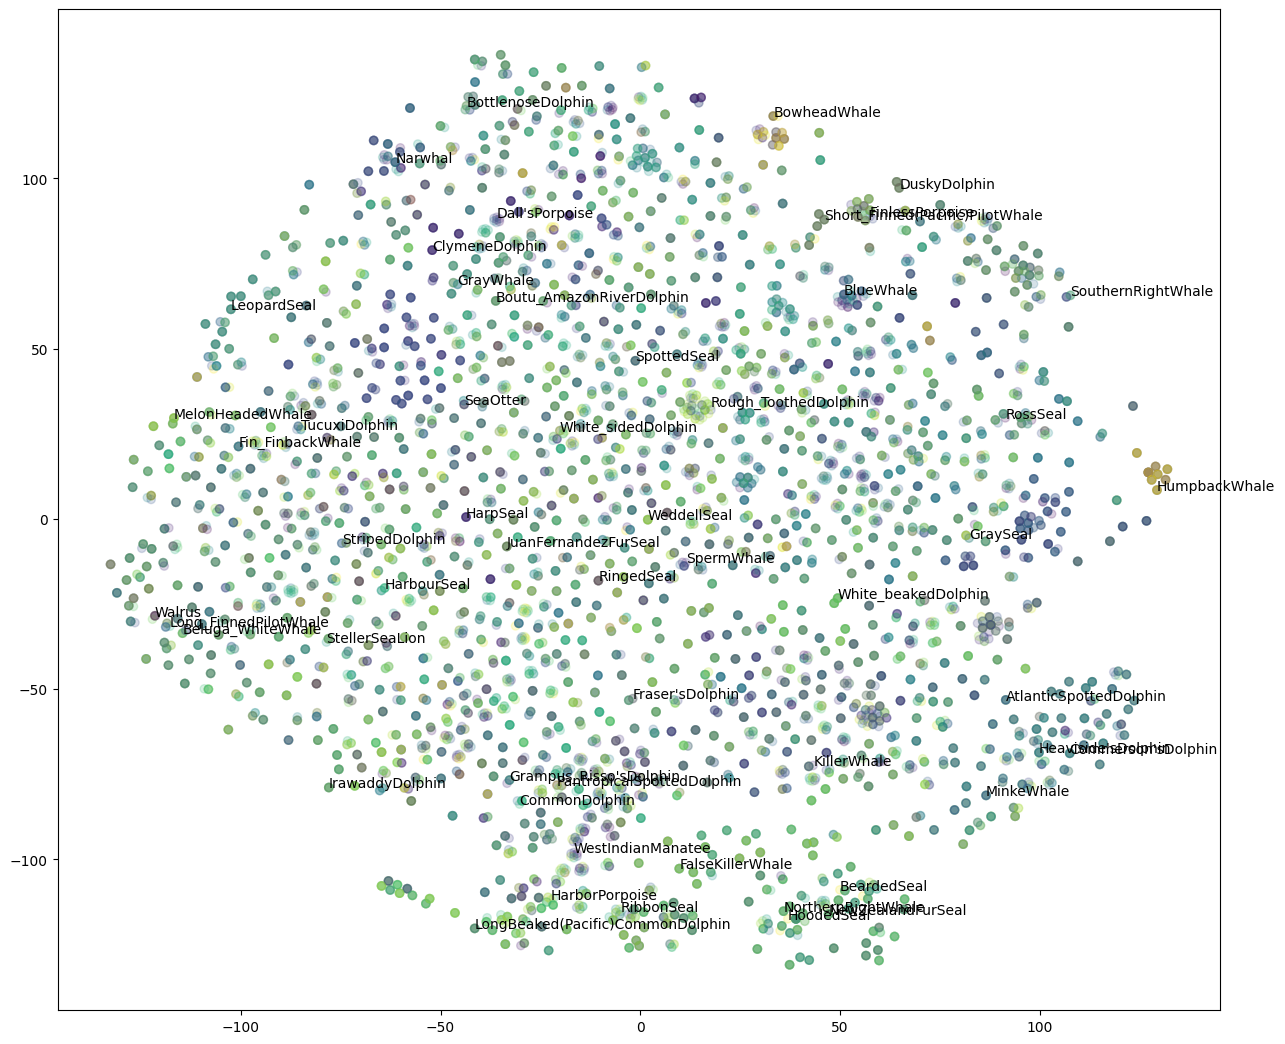

time: 989 ms (started: 2023-05-23 21:48:02 +00:00)


In [ ]:
plt.figure(figsize=(15, 13))
n_docs = df_for_dataset['label_encoded'].max()
idx = np.arange(df_for_dataset['label_encoded'].max())
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(
        T[:, 0], T[:, 1],
        c=df_for_dataset['label_encoded'],
        alpha=0.2
        )
viz_titles = [df_for_dataset[df_for_dataset['label_encoded']==i]['class'].unique()[0] for i in valid_idx]
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(
            label,
            xy=(x, y),
            xytext=(0, 0),
            textcoords='offset points'
            )

## Pipeline (data generation)
---
Se implemento un pipline de alimentación de datos para el modelo de deep learning. Este se encarga de la transformación y procesamiento de los datos para su posteriore entreda al modelo. Dicho pipeline se implmentó con las siguiente etapas:

* **Shuffle:** Se realiza una mezcla aleatoria de los datos
* **Repeat:** La cadena de alimentación de datos se repite indefinidamente hasta que se termine el entrenamiento
* **Batch:** Los datos se agrupan en una serie de baches para alimentar el modelo en pasos sucesivos.


In [ ]:
X_train_embed = df_for_dataset['embedings'].apply(ast.literal_eval).tolist()
X_val_embed = X_val['embedings'].apply(ast.literal_eval).tolist()
# Define el generador de datos
main_ds_train = tf.data.Dataset.from_tensor_slices((X_train_embed,
                                                    df_for_dataset['label_encoded']))
main_ds_val = tf.data.Dataset.from_tensor_slices((X_val_embed,
                                              y_val['label_encoded']))
# Aleatoriza el orden de los datos de entrenamiento
main_ds_train = main_ds_train.cache().shuffle(buffer_size=df_for_dataset.shape[0])
main_ds_val = main_ds_val.cache().shuffle(buffer_size=X_val.shape[0])
# Numero total de datos del subconjunto
# num_examples = df_for_dataset.shape[0]
# Define los tamanos de los conjuntos de entreneminto y validacion
train_size = df_for_dataset.shape[0]
val_size = X_val.shape[0]
print(f'Train size: {train_size}, validation size: {val_size}')
# Divide los datos en conjuntos de: entrenamiento y validation
train_data = main_ds_train.repeat()
val_data = main_ds_val.repeat()
# Define tamano del batch
batch_size = 64
# Define los batch para los conjuntos train y validation
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data.element_spec

Train size: 15563, validation size: 4202


(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

time: 29.4 s (started: 2023-05-23 03:44:25 +00:00)


In [ ]:
# batch_1_train = iter(main_ds.take(1)).next()
batch_1_train = iter(train_data.take(1)).next()
batch_1_train

(<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
 array([[0.        , 1.1009048 , 0.5407007 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01298703, 1.4111027 , ..., 0.4822235 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.6884139 , 1.0293541 , ..., 0.5300326 , 0.        ,
         0.        ],
        [0.00369299, 0.7434558 , 0.17000104, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 2.3320642 , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([35, 14, 23, 44, 34,  1, 14, 34, 13, 34, 14,  2, 46, 23,  3, 14,  2,
        35, 14, 23, 39, 34, 50,  9, 34, 39, 20, 29, 20,  3, 18, 39, 14, 14,
        23, 34, 36, 54, 45, 29, 44,  5, 20, 31, 11, 34, 53,  2, 29, 11, 34,
        29, 14, 42, 46,  2, 36, 39, 54,  3, 54, 13, 36, 54])>)

time: 84.9 ms (started: 2023-05-23 03:45:03 +00:00)


## Definición del modelo y entrenamiento
---
En este apartado se definió la arquitectura del modelo junto con la cantidad de épocas y pasos para el proceso de entrenamiento.

In [ ]:
# Define la parte superior del modelo para Calentamiento (Warming Up)
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(55)], name='my_model')
# Resumen de las capas superiores de salida
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 55)                28215     
                                                                 
Total params: 553,015
Trainable params: 553,015
Non-trainable params: 0
_________________________________________________________________
time: 197 ms (started: 2023-05-23 05:59:22 +00:00)


In [ ]:
# Compilacion: define funcion de perdida y optimizador
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])
# Define Callbacks para monitores de la perdida en validacion
dir = '/content/drive/MyDrive/Proyecto/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(dir,'val_checkpoint.h5'),
                                                      monitor="val_loss",
                                                      verbose=True,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      mode="min")
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            mode="min",
                                            restore_best_weights=True)
callbacks = [checkpoint, stopping]

time: 8.4 ms (started: 2023-05-23 03:45:16 +00:00)


In [ ]:
# Entrenamiento numero: 1
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 600,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)


Epoch 1/600
242/243 [============================>.] - ETA: 0s - loss: 2.3864 - accuracy: 0.3293
Epoch 1: val_loss improved from inf to 2.13482, saving model to /content/drive/MyDrive/Proyecto/val_checkpoint.h5
243/243 [==============================] - 3s 4ms/step - loss: 2.3861 - accuracy: 0.3293 - val_loss: 2.1348 - val_accuracy: 0.3599
Epoch 2/600
223/243 [==========================>...] - ETA: 0s - loss: 2.1082 - accuracy: 0.3725
Epoch 2: val_loss improved from 2.13482 to 2.03148, saving model to /content/drive/MyDrive/Proyecto/val_checkpoint.h5
243/243 [==============================] - 1s 3ms/step - loss: 2.1030 - accuracy: 0.3736 - val_loss: 2.0315 - val_accuracy: 0.3885
Epoch 3/600
243/243 [==============================] - ETA: 0s - loss: 2.0107 - accuracy: 0.3886
Epoch 3: val_loss improved from 2.03148 to 1.97497, saving model to /content/drive/MyDrive/Proyecto/val_checkpoint.h5
243/243 [==============================] - 1s 3ms/step - loss: 2.0107 - accuracy: 0.3886 - val_lo

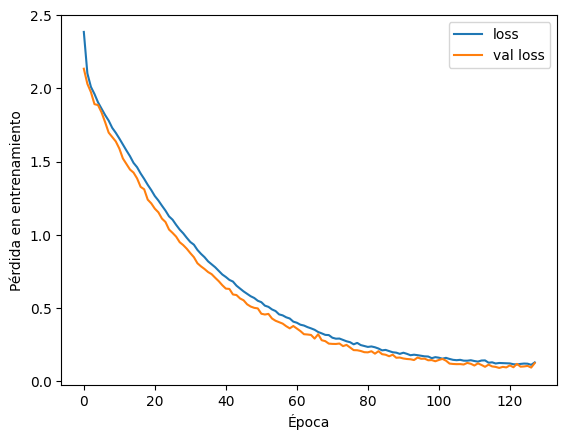

time: 430 ms (started: 2023-05-23 03:47:05 +00:00)


In [ ]:
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [ ]:
dir = '/content/drive/MyDrive/Proyecto/'
my_model.load_weights(os.path.join(dir,'val_checkpoint.h5'))

time: 334 ms (started: 2023-05-23 06:00:02 +00:00)


## Evaluación del modelo
---
Para esta etapa se emplearon diferentes métricas para evaluar el desempeño del modelo. Para esto se utilizó el data set de evaluación para determinar el desempeño del modelo utilizando metricas como:
* Precisión
* Sensitividad (recall)
* F1-Score
* Exactitud

In [ ]:
X_test_embed = X_test['embedings'].apply(ast.literal_eval).tolist()
# Predice los logits utilizando el modelo `my_model` en los datos de prueba `X_test`
pred_logits = my_model.predict(X_test_embed)
# Aplica la función de softmax a los logits para obtener probabilidades normalizadas
pred_prop = tf.nn.softmax(pred_logits)
# Codifica las etiquetas predichas al encontrar el índice del valor máximo a lo largo del eje 1
pred_label_encode = tf.argmax(pred_prop, axis=1)

49/49 [==============================] - 0s 1ms/step
time: 9.13 s (started: 2023-05-23 05:12:31 +00:00)


In [ ]:
# Importa todas las métricas de sklearn
from sklearn.metrics import *
# Imprime el informe de clasificación
# Comparando las etiquetas reales (y_test) con las etiquetas predichas (pred_label_encode)flip_idx_label_dict = {value: key for key, value in idx_label_dict.items()}
print(classification_report(y_test['label_encoded'], pred_label_encode))

              precision    recall  f1-score   support

           1       0.90      0.98      0.94        54
           2       0.98      1.00      0.99        56
           3       0.96      0.99      0.97        67
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00        13
          11       1.00      0.95      0.97        39
          12       1.00      1.00      1.00         1
          13       1.00      0.97      0.98        29
          14       1.00      1.00      1.00       272
          15       1.00      1.00      1.00         8
          18       1.00      1.00      1.00         5
          20       1.00      1.00      1.00        34
          21       1.00      1.00      1.00         8
          23       1.00    

## Aplicación del modelo
---
Finalmente se pretende aplicar el modelo utilizando señales de audio aleatorias para observar su desempeño junto con las probabilidades para cada clase a la hora de hacer una clasificación puntual. Esto nos puede dar una idea como el modelo esta operando y en que clases hay mayor dificultad debido a que pueden compartir una alta probabilidad a la hora de hacer la elecció.

In [ ]:
# Load specific columns from a CSV file
dir = '/content/drive/MyDrive/Proyecto/'
df_for_dataset = pd.read_csv(os.path.join(dir,'df_train_aumenta_TOT_embed.csv'), usecols=['class', 'label_encoded', 'embedings'], nrows=500)

In [ ]:
# Definimos el directorio base
dir = './content/data/'
# Optenemos una lista de las rutas locales de cada audio
list_paths = get_list_path_from_subfolders(dir)
# Crea un df con dos columans clases y rutas
df_aplica =  get_df_labels_paths(list_paths)
# Elige una clase y una ruta aleatoria
signal_path, label = get_rand_path(df_aplica)
# Convierte la senal en array
signal_original, sr = librosa.load(signal_path)
signal_original_prep, sr = proproces_for_map(tf.convert_to_tensor(signal_original),
                                         tf.convert_to_tensor(sr))
# Embeding de la senal
signal_original_embed = extract_embedding(signal_original_prep).numpy().tolist()[0]
signal_original_embed = tf.convert_to_tensor(signal_original_embed)
# Predice los logits utilizando el modelo `my_model` en los datos de prueba `X_test`
pred_logits = my_model.predict(tf.expand_dims(signal_original_embed, axis=0))
pred_prop = tf.nn.softmax(pred_logits)
pred_label_encode = tf.argmax(pred_prop, axis=1)
# Aplica la función de softmax a los logits para obtener probabilidades normalizadas
#pred_label_encode = pred_logits.mean(axis=0).argmax()
encoded_to_class = lambda encod: ''.join(df_for_dataset[df_for_dataset['label_encoded']==encod]['class'].unique())
# Comparacion entre la clase real y la predicha
print(f"Original: {label} vs. Predicha: {encoded_to_class(pred_label_encode)}")
ipd.Audio(signal_original, rate=sr)

1/1 [==============================] - 0s 16ms/step
Original: StripedDolphin vs. Predicha: StripedDolphin


time: 152 ms (started: 2023-05-23 06:20:05 +00:00)


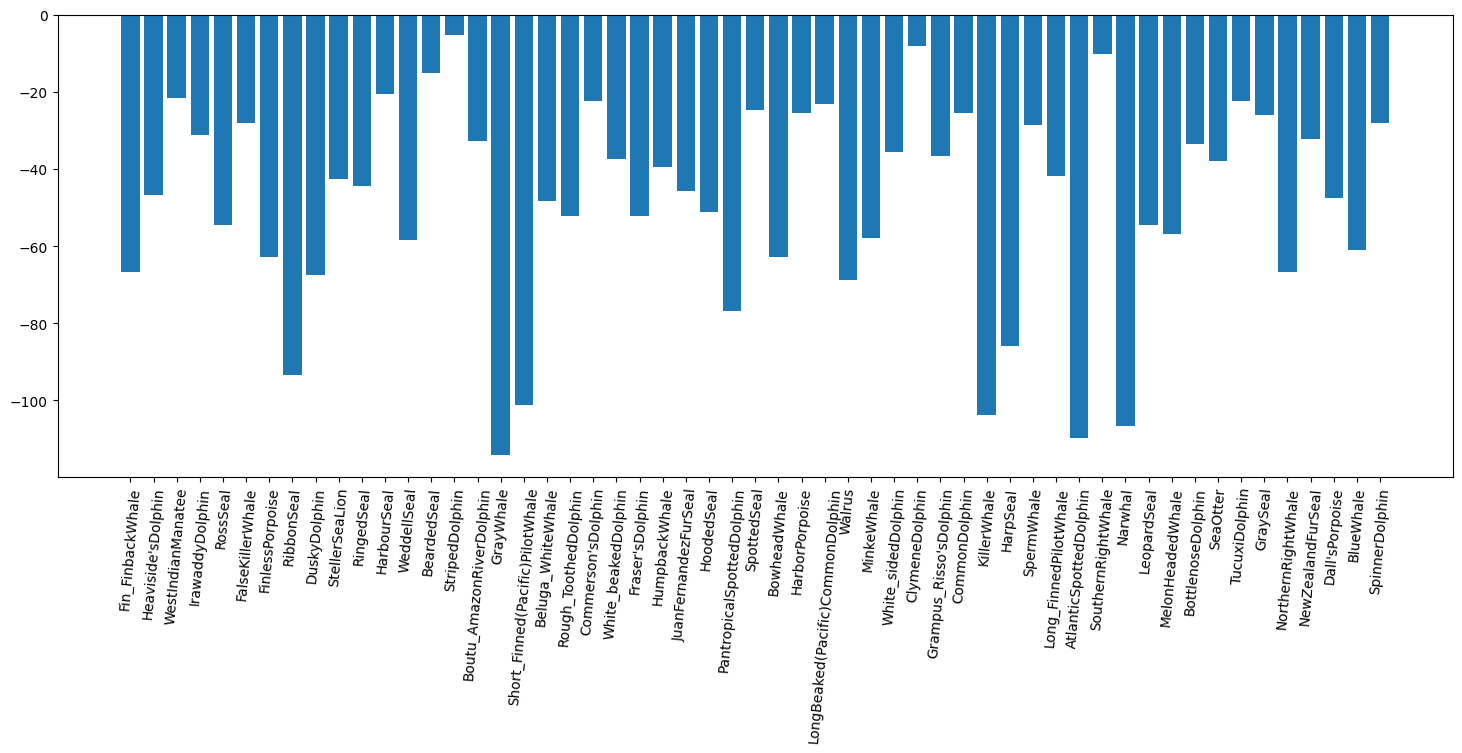

time: 579 ms (started: 2023-05-23 06:20:13 +00:00)


In [ ]:
plt.figure(figsize=(18,6))
plt.bar([encoded_to_class(i) for i in df_for_dataset['label_encoded'].sort_values().unique()], pred_logits.squeeze())
plt.xticks(rotation=85);

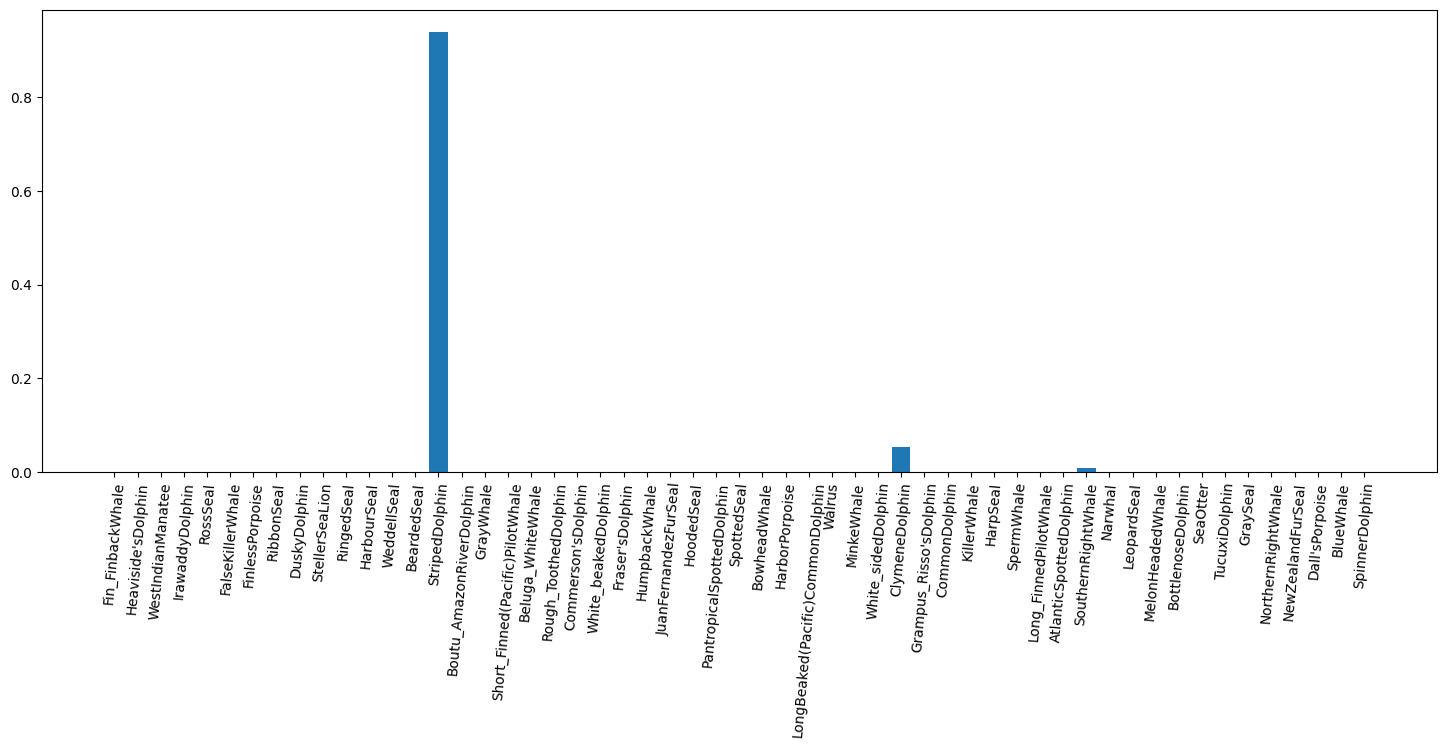

time: 530 ms (started: 2023-05-23 06:20:23 +00:00)


In [ ]:
plt.figure(figsize=(18,6))
plt.bar([encoded_to_class(i) for i in df_for_dataset['label_encoded'].sort_values().unique()], pred_prop.numpy().squeeze())
plt.xticks(rotation=85);

## Conclusión
---
Se puede concluir que, en general, el modelo muestra un buen desempeño, con altos valores de precisión, recall y F1-score para la mayoría de las clases. La precisión promedio, el recall promedio junto con el ponderado son altos, lo que indica que en general el modelo tiene un buen rendimiento para este conjunto de datos.

Sin embargo, a la hora de aplicar el modelo se observa que no siempre es capaz de predecir la clase para un audio elegido al azar. Además, en el caso de la clase 40 (*Long Finned Pilot whale*) donde el modelo presenta un menor desempeño, se evidencian métricas más bajas en comparación con las de las demás clases. Esto puede deberse a la complejidad del problema, dado que, como se observó en el gáfico t-SNE, la agrupación de las diferentes categorías en el espacio latente no es sencilla. Dicha dificultad puede observarse en las múltiples categorías que se solapan entre sí (observadas en el espacio latente), haciendo difícil la discriminación entre las mismas.

Adicionalmente, algunos factores como la similitud de vocalizaciones entre mamíferos junto con la mala calidad de algunos de los audios pueden explicar el el cuestionado desempeño del modelo a la hora de ser aplicado con datos aleatorios. Por lo que sería impoortante explorar técnicas de reducción de clases junto con nuevas arquitecturas de red para el clasificador y posiblemente nuevos tamaños de *embeddings* para mejorar el desempeño del modelo.

Es decir, aunque el modelo presente buenas métricas de desempeño, estas no se evidencian a la hora de su aplicación. Por tanto, el modelo debe seguir afinandose para ser aplicado en un contexto de investigación o de industria. Sin embargo, resulta evidente que el modelo es útil en el sentido en que este supera la aleatoriedad, logrando predecir muchas veces la categoría de mamífero para una señal de audio dada.


## Referencias
---
> Audio Data Preparation and Augmentation | TensorFlow I/O. TensorFlow. Retrieved May 23, 2023, from https://www.tensorflow.org/io/tutorials/audio

> Transfer learning with YAMNet for environmental sound classification | TensorFlow Core. TensorFlow. Retrieved May 23, 2023, from https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

> Watkins Marine Mammal Sound Database. Retrieved May 23, 2023, from https://cis.whoi.edu/science/B/whalesounds/index.cfm